In [40]:
# General imports
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# Custom imports
from modules import RC_model

# ============ RC model configuration and hyperparameter values ============
config = {}
config['dataset_name'] = 'human speaking consonant vowel syllables'

config['seed'] = 1
np.random.seed(config['seed'])

# Hyperarameters of the reservoir
config['n_internal_units'] = 450        # size of the reservoir
config['spectral_radius'] = 0.59        # largest eigenvalue of the reservoir
config['leak'] = 0.6                    # amount of leakage in the reservoir state update (None or 1.0 --> no leakage)
config['connectivity'] = 0.25           # percentage of nonzero connections in the reservoir
config['input_scaling'] = 0.1           # scaling of the input weights
config['noise_level'] = 0.01            # noise in the reservoir state update
config['n_drop'] = 5                    # transient states to be dropped
config['bidir'] = True                  # if True, use bidirectional reservoir
config['circ'] = False                  # use reservoir with circle topology

# Dimensionality reduction hyperparameters
config['dimred_method'] ='tenpca'       # options: {None (no dimensionality reduction), 'pca', 'tenpca'}
config['n_dim'] = 75                    # number of resulting dimensions after the dimensionality reduction procedure

# Type of MTS representation
config['mts_rep'] = 'reservoir'         # MTS representation:  {'last', 'mean', 'output', 'reservoir'}
config['w_ridge_embedding'] = 10.0      # regularization parameter of the ridge regression

# Type of readout
config['readout_type'] = 'lin'          # readout used for classification: {'lin', 'mlp', 'svm'}

# Linear readout hyperparameters
config['w_ridge'] = 5.0                 # regularization of the ridge regression readout

# SVM readout hyperparameters
config['svm_gamma'] = 0.005             # bandwith of the RBF kernel
config['svm_C'] = 5.0                   # regularization for SVM hyperplane

# MLP readout hyperparameters
config['mlp_layout'] = (10,10)          # neurons in each MLP layer
config['num_epochs'] = 2000             # number of epochs 
config['w_l2'] = 0.001                  # weight of the L2 regularization
config['nonlinearity'] = 'relu'         # type of activation function {'relu', 'tanh', 'logistic', 'identity'}

print(config)

#Load dataset 
#75/25 train test split
data = np.load('EC9.npz', allow_pickle=True)
cons = data['cons'] # shape is [N,T,V]
Xtr = cons[0:1240]

temp_label = data['label']  # shape is [N,1]
le.fit(temp_label)
label=le.transform(temp_label)
Ytr = label[0:1240]

Xte = cons[1240:1653]
Yte = label[1240:1653]

#print('Loaded '+config['dataset_name']+' - Tr: '+ str(Xtr.shape)+', Te: '+str(Xte.shape))

# One-hot encoding for labels
# onehot_encoder = OneHotEncoder(sparse=False)
# Ytr = onehot_encoder.fit_transform(Ytr)
# Yte = onehot_encoder.transform(Yte)

# ============ Initialize, train and evaluate the RC model ============


{'dataset_name': 'human speaking consonant vowel syllables', 'seed': 1, 'n_internal_units': 450, 'spectral_radius': 0.59, 'leak': 0.6, 'connectivity': 0.25, 'input_scaling': 0.1, 'noise_level': 0.01, 'n_drop': 5, 'bidir': True, 'circ': False, 'dimred_method': 'tenpca', 'n_dim': 75, 'mts_rep': 'reservoir', 'w_ridge_embedding': 10.0, 'readout_type': 'lin', 'w_ridge': 5.0, 'svm_gamma': 0.005, 'svm_C': 5.0, 'mlp_layout': (10, 10), 'num_epochs': 2000, 'w_l2': 0.001, 'nonlinearity': 'relu'}


In [41]:
segment_len=[]
for i in range(len(cons)):
    segment_len.append(cons[i].shape[0])

In [42]:
print(len(segment_len))
print(min(segment_len))

1653
49


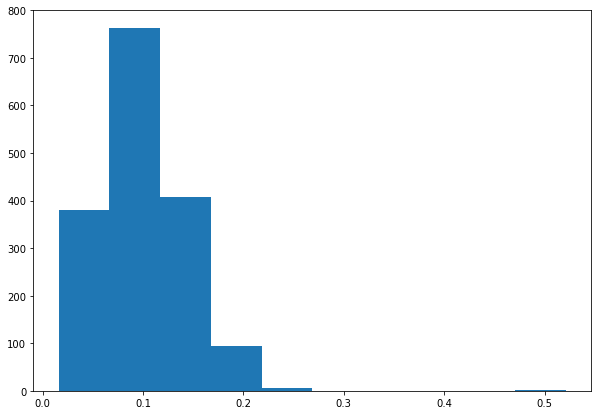

In [48]:
fs=3052
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(np.array(segment_len)/fs)
 
# Show plot
plt.show()

In [44]:
min_sample_size=min(segment_len)

temp=[]
for time_series in Xtr:
    temp.append(time_series[0:min_sample_size])
temp=np.array(temp)
print(temp.shape)
Xtr=temp

temp=[]
for time_series in Xte:
    temp.append(time_series[0:min_sample_size])
temp=np.array(temp)
print(temp.shape)
Xte=temp

(1240, 49, 256)
(413, 49, 256)


In [55]:
classifier =  RC_model(
                        reservoir=None,     
                        n_internal_units=config['n_internal_units'],
                        spectral_radius=config['spectral_radius'],
                        leak=config['leak'],
                        connectivity=config['connectivity'],
                        input_scaling=config['input_scaling'],
                        noise_level=config['noise_level'],
                        circle=config['circ'],
                        n_drop=config['n_drop'],
                        bidir=config['bidir'],
                        dimred_method=config['dimred_method'], 
                        n_dim=config['n_dim'],
                        mts_rep=config['mts_rep'],
                        w_ridge_embedding=config['w_ridge_embedding'],
                        readout_type=config['readout_type'],            
                        w_ridge=config['w_ridge'],              
                        mlp_layout=config['mlp_layout'],
                        num_epochs=config['num_epochs'],
                        w_l2=config['w_l2'],
                        nonlinearity=config['nonlinearity'], 
                        svm_gamma=config['svm_gamma'],
                        svm_C=config['svm_C']
                        )

tr_time = classifier.train(Xtr, Ytr)
print('Training time = %.2f seconds'%tr_time)

accuracy, f1 = classifier.test(Xte, Yte)
print('Accuracy = %.3f, F1 = %.3f'%(accuracy, f1))

Training time = 0.15 seconds
(413, 5700)
(413,)


AxisError: axis 1 is out of bounds for array of dimension 1

In [54]:
# %load modules.py
# General imports
import numpy as np
import time
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from scipy.spatial.distance import pdist, cdist, squareform

# Custom imports
from reservoir import Reservoir
from tensorPCA import tensorPCA


def compute_test_scores(pred_class, Yte):
    """
    Wrapper to compute classification accuracy and F1 score
    """
    
    true_class = np.argmax(Yte, axis=1)
    
    accuracy = accuracy_score(true_class, pred_class)
    if Yte.shape[1] > 2:
        f1 = f1_score(true_class, pred_class, average='weighted')
    else:
        f1 = f1_score(true_class, pred_class, average='binary')

    return accuracy, f1

            
class RC_model(object):
    
    def __init__(self,
              # reservoir
              reservoir=None,     
              n_internal_units=None,
              spectral_radius=None,
              leak=None,
              connectivity=None,
              input_scaling=None,
              noise_level=None,
              n_drop=None,
              bidir=False,
              circle=False,
              # dim red
              dimred_method=None, 
              n_dim=None,
              # representation
              mts_rep=None,
              w_ridge_embedding=None,
              # readout
              readout_type=None,               
              w_ridge=None,              
              mlp_layout=None,
              num_epochs=None,
              w_l2=None,
              nonlinearity=None, 
              svm_gamma=1.0,
              svm_C=1.0,
              ):
        """
        Build and evaluate a RC-based classifier.
        The training and test MTS are multidimensional arrays of shape [N,T,V], with
            - N = number of samples
            - T = number of time steps in each sample
            - V = number of variables in each sample
        Training and test labels have shape [N,C], with C the number of classes
        
        The dataset consists of:
            X, Y = training data and respective labels
            Xte, Yte = test data and respective labels
            
        Reservoir parameters:
            reservoir = precomputed reservoir (oject of class 'Reservoir');
                if None, the following structural hyperparameters must be specified
            n_internal_units = processing units in the reservoir
            spectral_radius = largest eigenvalue of the reservoir matrix of connection weights
            leak = amount of leakage in the reservoir state update (optional)
            connectivity = percentage of nonzero connection weights
            input_scaling = scaling of the input connection weights
            noise_level = deviation of the Gaussian noise injected in the state update
            n_drop = number of transient states to drop
            bidir = use a bidirectional reservoir (True or false)
                
        Dimensionality reduction parameters:
            dimred_method = procedure for reducing the number of features in the sequence of reservoir states;
                possible options are: None (no dimensionality reduction), 'pca' or 'tenpca'
            n_dim = number of resulting dimensions after the dimensionality reduction procedure
            
        Representation parameters:
            mts_rep = type of MTS representation. It can be 'last' (last state), 'output' (output model space),
                or 'reservoir' (reservoir model space)
            w_ridge_embedding = regularization parameter of the ridge regression in the output model space
                and reservoir model space representation; ignored if mts_rep == None
            
        Readout parameters:
            readout_type = type of readout used for classification. It can be 'lin' (ridge regression), 
                'mlp' (multiplayer perceptron), 'svm' (support vector machine), or None.
                If None, the input representations will be saved instead: this is useful for clustering and visualization.
            w_ridge = regularization parameter of the ridge regression readout (only for readout_type=='lin')              
            mlp_layout = tuple with the sizes of MLP layers, e.g. (20, 10) defines a MLP with 2 layers 
                of 20 and 10 units respectively. (only for readout_type=='mlp')
            num_epochs = number of iterations during the optimization (only for readout_type=='mlp')
            w_l2 = weight of the L2 regularization (only for readout_type=='mlp')
            nonlinearity = type of activation function {'relu', 'tanh', 'logistic', 'identity'} (only for readout_type=='mlp')
            svm_gamma = bandwith of the RBF kernel (only for readout_type=='svm')
            svm_C = regularization for SVM hyperplane (only for readout_type=='svm')
        """
        self.n_drop=n_drop
        self.bidir=bidir
        self.dimred_method=dimred_method
        self.mts_rep=mts_rep
        self.readout_type=readout_type
        self.svm_gamma=svm_gamma
                        
        # Initialize reservoir
        if reservoir is None:
            self._reservoir = Reservoir(n_internal_units=n_internal_units,
                                  spectral_radius=spectral_radius,
                                  leak=leak,
                                  connectivity=connectivity,
                                  input_scaling=input_scaling,
                                  noise_level=noise_level,
                                  circle=circle)
        else:
            self._reservoir = reservoir
                
        # Initialize dimensionality reduction method
        if dimred_method is not None:
            if dimred_method.lower() == 'pca':
                self._dim_red = PCA(n_components=n_dim)            
            elif dimred_method.lower() == 'tenpca':
                self._dim_red = tensorPCA(n_components=n_dim)
            else:
                raise RuntimeError('Invalid dimred method ID')
                
        # Initialize ridge regression model
        if mts_rep=='output' or mts_rep=='reservoir':
            self._ridge_embedding = Ridge(alpha=w_ridge_embedding, fit_intercept=True)
                        
        # Initialize readout type            
        if self.readout_type is not None:
            
            if self.readout_type == 'lin': # Ridge regression
                self.readout = Ridge(alpha=w_ridge)        
            elif self.readout_type == 'svm': # SVM readout
                self.readout = SVC(C=svm_C, kernel='precomputed')          
            elif readout_type == 'mlp': # MLP (deep readout)  
                # pass
                self.readout = MLPClassifier(
                    hidden_layer_sizes=mlp_layout, 
                    activation=nonlinearity, 
                    alpha=w_l2,
                    batch_size=32, 
                    learning_rate='adaptive', # 'constant' or 'adaptive'
                    learning_rate_init=0.001, 
                    max_iter=num_epochs, 
                    early_stopping=False, # if True, set validation_fraction > 0
                    validation_fraction=0.0 # used for early stopping
                    )
            else:
                raise RuntimeError('Invalid readout type')  
        
        
    def train(self, X, Y=None):
        
        time_start = time.time()
        
        # ============ Compute reservoir states ============ 
        res_states = self._reservoir.get_states(X, n_drop=self.n_drop, bidir=self.bidir)
        
        # ============ Dimensionality reduction of the reservoir states ============  
        if self.dimred_method.lower() == 'pca':
            # matricize
            N_samples = res_states.shape[0]
            res_states = res_states.reshape(-1, res_states.shape[2])                   
            # ..transform..
            red_states = self._dim_red.fit_transform(res_states)          
            # ..and put back in tensor form
            red_states = red_states.reshape(N_samples,-1,red_states.shape[1])          
        elif self.dimred_method.lower() == 'tenpca':
            red_states = self._dim_red.fit_transform(res_states)       
        else: # Skip dimensionality reduction
            red_states = res_states

        # ============ Generate representation of the MTS ============
        coeff_tr = []
        biases_tr = []   
        
        # Output model space representation
        if self.mts_rep=='output':
            if self.bidir:
                X = np.concatenate((X,X[:, ::-1, :]),axis=2)                
                
            for i in range(X.shape[0]):
                self._ridge_embedding.fit(red_states[i, 0:-1, :], X[i, self.n_drop+1:, :])
                coeff_tr.append(self._ridge_embedding.coef_.ravel())
                biases_tr.append(self._ridge_embedding.intercept_.ravel())
            input_repr = np.concatenate((np.vstack(coeff_tr), np.vstack(biases_tr)), axis=1)
            
        # Reservoir model space representation
        elif self.mts_rep=='reservoir':
            for i in range(X.shape[0]):
                self._ridge_embedding.fit(red_states[i, 0:-1, :], red_states[i, 1:, :])
                coeff_tr.append(self._ridge_embedding.coef_.ravel())
                biases_tr.append(self._ridge_embedding.intercept_.ravel())
            input_repr = np.concatenate((np.vstack(coeff_tr), np.vstack(biases_tr)), axis=1)
        
        # Last state representation        
        elif self.mts_rep=='last':
            input_repr = red_states[:, -1, :]
            
        # Mean state representation        
        elif self.mts_rep=='mean':
            input_repr = np.mean(red_states, axis=1)
            
        else:
            raise RuntimeError('Invalid representation ID')            
            
        # ============ Apply readout ============
        if self.readout_type == None: # Just store the input representations
            self.input_repr = input_repr
            
        elif self.readout_type == 'lin': # Ridge regression
            self.readout.fit(input_repr, Y)          
            
        elif self.readout_type == 'svm': # SVM readout
            Ktr = squareform(pdist(input_repr, metric='sqeuclidean')) 
            Ktr = np.exp(-self.svm_gamma*Ktr)
            self.readout.fit(Ktr, np.argmax(Y,axis=1))
            self.input_repr_tr = input_repr # store them to build test kernel
            
        elif self.readout_type == 'mlp': # MLP (deep readout)
            self.readout.fit(input_repr, Y)
                        
        tot_time = (time.time()-time_start)/60
        return tot_time

            
    def test(self, Xte, Yte):

        # ============ Compute reservoir states ============
        res_states_te = self._reservoir.get_states(Xte, n_drop=self.n_drop, bidir=self.bidir) 
        
        # ============ Dimensionality reduction of the reservoir states ============ 
        if self.dimred_method.lower() == 'pca':
            # matricize
            N_samples_te = res_states_te.shape[0]
            res_states_te = res_states_te.reshape(-1, res_states_te.shape[2])                    
            # ..transform..
            red_states_te = self._dim_red.transform(res_states_te)            
            # ..and put back in tensor form
            red_states_te = red_states_te.reshape(N_samples_te,-1,red_states_te.shape[1])            
        elif self.dimred_method.lower() == 'tenpca':
            red_states_te = self._dim_red.transform(res_states_te)        
        else: # Skip dimensionality reduction
            red_states_te = res_states_te             
        
        # ============ Generate representation of the MTS ============
        coeff_te = []
        biases_te = []   
        
        # Output model space representation
        if self.mts_rep=='output':
            if self.bidir:
                Xte = np.concatenate((Xte,Xte[:, ::-1, :]),axis=2)  
                    
            for i in range(Xte.shape[0]):
                self._ridge_embedding.fit(red_states_te[i, 0:-1, :], Xte[i, self.n_drop+1:, :])
                coeff_te.append(self._ridge_embedding.coef_.ravel())
                biases_te.append(self._ridge_embedding.intercept_.ravel())
            input_repr_te = np.concatenate((np.vstack(coeff_te), np.vstack(biases_te)), axis=1)
        
        # Reservoir model space representation
        elif self.mts_rep=='reservoir':    
            for i in range(Xte.shape[0]):
                self._ridge_embedding.fit(red_states_te[i, 0:-1, :], red_states_te[i, 1:, :])
                coeff_te.append(self._ridge_embedding.coef_.ravel())
                biases_te.append(self._ridge_embedding.intercept_.ravel())
            input_repr_te = np.concatenate((np.vstack(coeff_te), np.vstack(biases_te)), axis=1)
    
        # Last state representation        
        elif self.mts_rep=='last':
            input_repr_te = red_states_te[:, -1, :]
            
        # Mean state representation        
        elif self.mts_rep=='mean':
            input_repr_te = np.mean(red_states_te, axis=1)
            
        else:
            raise RuntimeError('Invalid representation ID')   
            
        # ============ Apply readout ============
        if self.readout_type == 'lin': # Ridge regression        
            logits = self.readout.predict(input_repr_te)
            print(input_repr_te.shape)
            print(logits.shape)
            pred_class = np.argmax(logits, axis=1)
            
        elif self.readout_type == 'svm': # SVM readout
            Kte = cdist(input_repr_te, self.input_repr_tr, metric='sqeuclidean')
            Kte = np.exp(-self.svm_gamma*Kte)
            pred_class = self.readout.predict(Kte)
            
        elif self.readout_type == 'mlp': # MLP (deep readout)
            pred_class = self.readout.predict(input_repr_te)
            pred_class = np.argmax(pred_class, axis=1)
            
        accuracy, f1 = compute_test_scores(pred_class, Yte)
        return accuracy, f1

[672, 466, 272, 345, 336, 308, 285, 391, 312, 401, 336, 614, 141, 335, 304, 138, 182, 333, 285, 217, 178, 536, 363, 188, 100, 419, 146, 635, 220, 460, 204, 305, 403, 374, 132, 233, 526, 489, 176, 378, 249, 249, 202, 249, 49, 435, 595, 221, 239, 437, 305, 255, 670, 261, 478, 177, 387, 208, 275, 300, 221, 436, 157, 233, 425, 439, 186, 201, 327, 109, 515, 192, 316, 317, 319, 428, 75, 524, 267, 210, 367, 202, 373, 401, 427, 202, 565, 134, 451, 238, 470, 316, 334, 332, 357, 381, 618, 265, 343, 421, 374, 444, 457, 361, 287, 397, 270, 150, 197, 149, 252, 207, 252, 303, 382, 349, 304, 183, 487, 365, 204, 313, 526, 410, 132, 203, 586, 748, 482, 140, 134, 485, 377, 343, 428, 488, 627, 276, 399, 150, 369, 234, 216, 456, 513, 389, 359, 443, 227, 129, 280, 501, 549, 280, 103, 221, 395, 366, 189, 279, 277, 194, 335, 600, 108, 287, 670, 489, 260, 335, 492, 335, 561, 357, 182, 223, 250, 96, 487, 112, 271, 361, 150, 193, 216, 627, 507, 233, 487, 372, 205, 323, 400, 113, 556, 314, 368, 358, 507, 590, 36

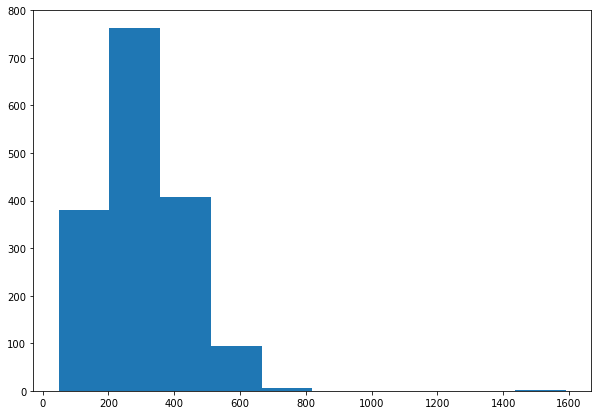